In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras as k
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,BatchNormalization,Activation,GlobalAveragePooling2D,Dropout,Dense,MaxPooling2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [3]:
# Load dataset directories
train = 'FER/train'
test = 'FER/test'

In [4]:
img_size=(48,48)
bth_size=32

# Augmenting Images for training set

trdatagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.1
)

# Normalization of the pixel values for test Set
tedatagen = ImageDataGenerator(rescale=1.0/255)

In [5]:
# Reading the training data from directory

traingen= trdatagen.flow_from_directory(
    train,
    target_size=img_size,
    batch_size=bth_size,
    color_mode='grayscale',  
    class_mode='categorical',
    shuffle=True,
    subset='training')

# Reading the testing data from directory

testgen = tedatagen.flow_from_directory(
    test,
    target_size=img_size,
    batch_size=bth_size,
    color_mode='grayscale', 
    class_mode='categorical',
    shuffle=False
)

Found 25841 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


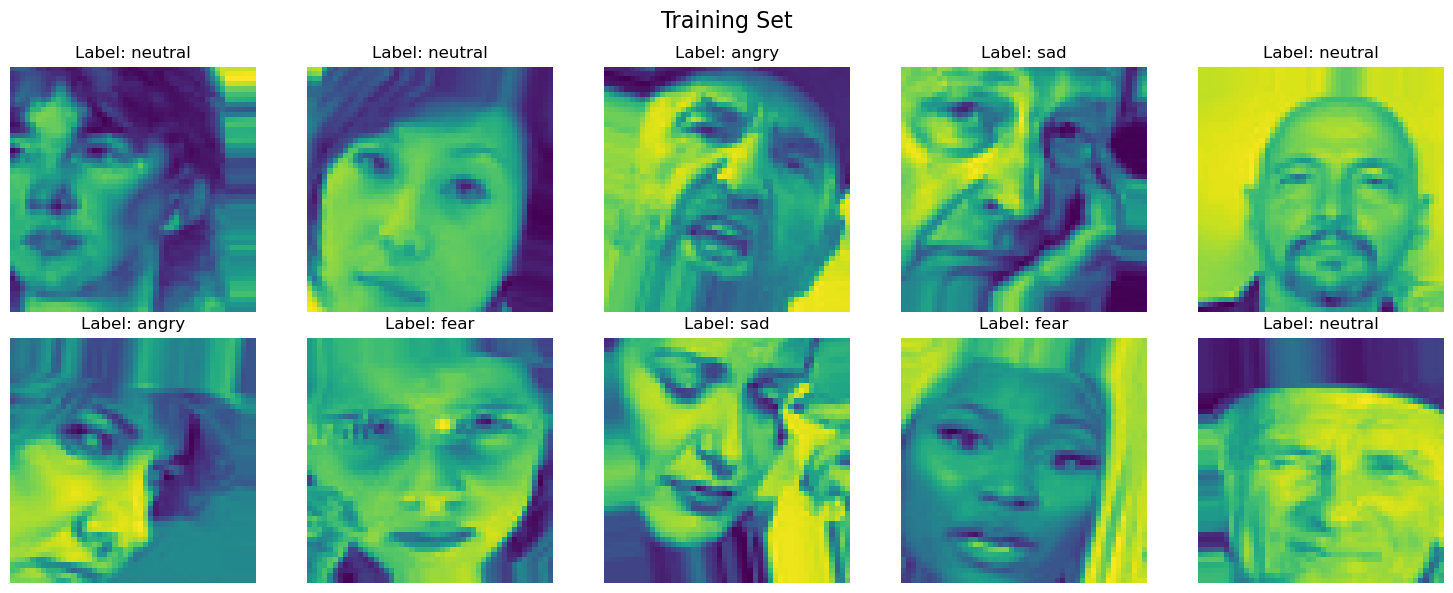

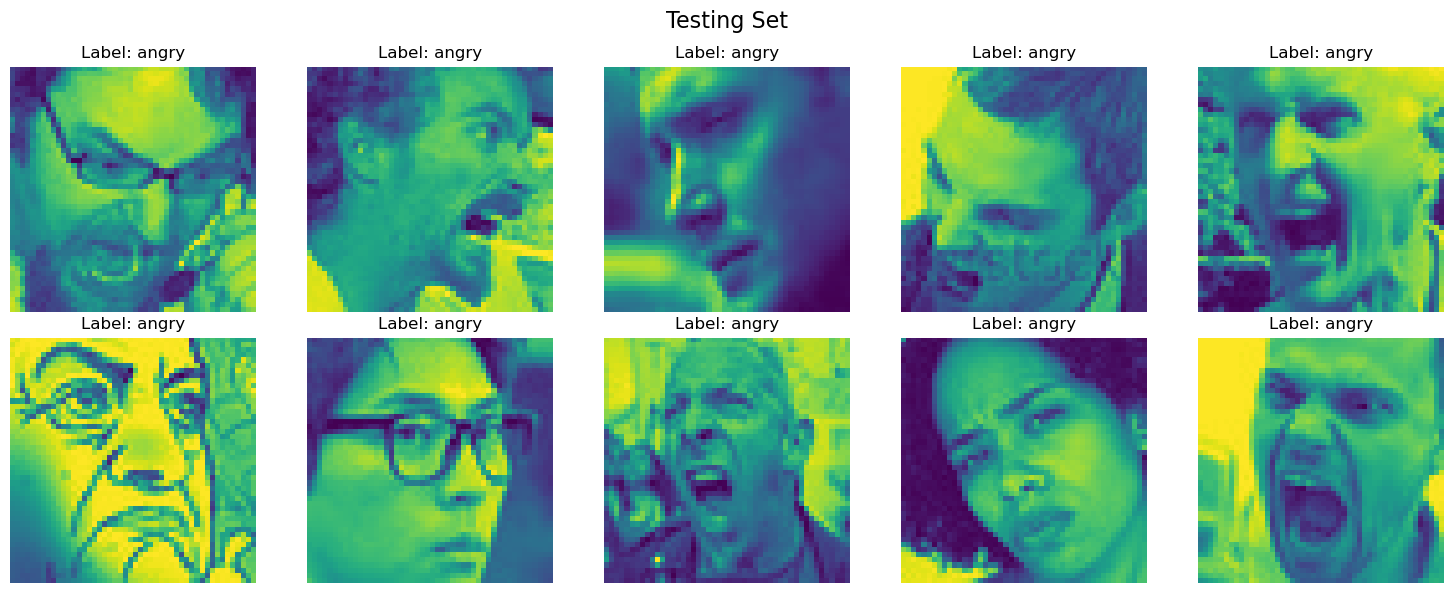

In [6]:
# Displaying the training and testing datsets (only 5 images from each dataset)

def plot_images_from_generator(generator, title, num_images=5, images_per_row=5):
    images, labels = next(generator)
    images = images[:num_images]
    labels = labels[:num_images]
    num_rows = (num_images + images_per_row - 1) // images_per_row
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    for i in range(num_images):
        img = images[i]
        label = labels[i]
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {list(generator.class_indices.keys())[label.argmax()]}")
    
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_images_from_generator(traingen, "Training Set", num_images=10, images_per_row=5)
plot_images_from_generator(testgen, "Testing Set", num_images=10, images_per_row=5)

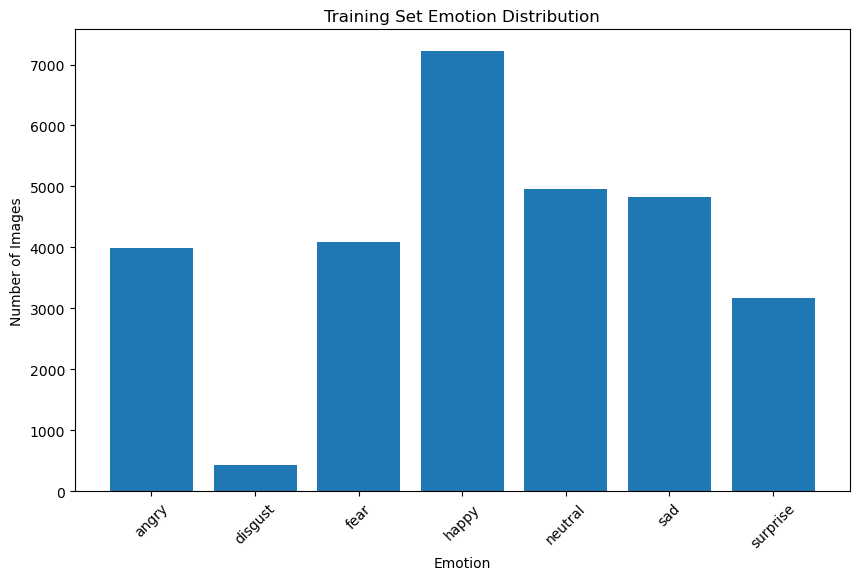

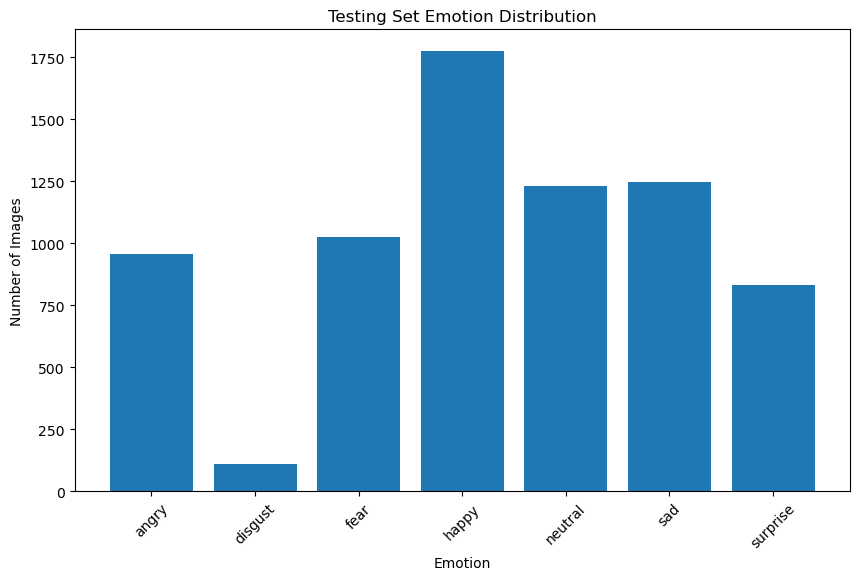

In [7]:
#class distribution

def plot_class_distribution(directory, title):
    class_names = os.listdir(directory)
    class_counts = []
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts.append(len(os.listdir(class_dir)))

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, class_counts)
    plt.title(title)
    plt.xlabel('Emotion')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train, "Training Set Emotion Distribution")
plot_class_distribution(test, "Testing Set Emotion Distribution")

In [8]:
# Label Map
label_map = {
    0:'Angry', 
    1:'Disgust',
    2:'Fear',
    3:'Happy', 
    4:'Sad', 
    5:'Surprise', 
    6:'Neutral'
}

In [9]:
# Defining CNN model
model = Sequential()

# CNN Layer 1
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48, 48, 1)))  
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# CNN Layer 2
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#CNN Layer 3
model.add(Conv2D(256, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Global Average Pooling layer is used instead of Flatten as it is more effiecient
model.add(GlobalAveragePooling2D())

#Dense Layer 1
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Dense Layer 2
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Output Layer
model.add(Dense(7, activation='softmax'))

#Adam Optimizer
opt = k.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

C:\Users\RAVI RAJ\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 639,239 (2.44 MB)

 Trainable params: 636,807 (2.43 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [10]:
#Implementing Early Stopping and Learning Rate Reduction
es=EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)
lr=ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, verbose=1, min_delta=0.0001)

callbacks_list=[es,lr]

In [11]:
history = model.fit(
    traingen,
    epochs=100,
    validation_data=testgen,
    callbacks=callbacks_list
)

Epoch 1/100


C:\Users\RAVI RAJ\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


808/808 ━━━━━━━━━━━━━━━━━━━━ 163s 194ms/step - accuracy: 0.1897 - loss: 2.4110 - val_accuracy: 0.2379 - val_loss: 1.8970 - learning_rate: 0.0010
Epoch 2/100
808/808 ━━━━━━━━━━━━━━━━━━━━ 62s 77ms/step - accuracy: 0.2360 - loss: 1.8589 - val_accuracy: 0.2559 - val_loss: 1.7847 - learning_rate: 0.0010
Epoch 3/100
808/808 ━━━━━━━━━━━━━━━━━━━━ 66s 82ms/step - accuracy: 0.2675 - loss: 1.7787 - val_accuracy: 0.3093 - val_loss: 1.8325 - learning_rate: 0.0010
Epoch 4/100
808/808 ━━━━━━━━━━━━━━━━━━━━ 68s 84ms/step - accuracy: 0.3379 - loss: 1.6563 - val_accuracy: 0.3488 - val_loss: 1.6738 - learning_rate: 0.0010
Epoch 5/100
808/808 ━━━━━━━━━━━━━━━━━━━━ 62s 77ms/step - accuracy: 0.3889 - loss: 1.5661 - val_accuracy: 0.3523 - val_loss: 1.6776 - learning_rate: 0.0010
Epoch 6/100
808/808 ━━━━━━━━━━━━━━━━━━━━ 62s 77ms/step - accuracy: 0.4204 - loss: 1.5038 - val_accuracy: 0.4108 - val_loss: 1.4999 - learning_rate: 0.0010
Epoch 7/100
808/808 ━━━━━━━━━━━━━━━━━━━━ 62s 76ms/step - accuracy: 0.4454 - loss

In [12]:
#Predicting
test_loss, test_accuracy = model.evaluate(testgen)

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5502 - loss: 1.1549


Test Accuracy: 0.62
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.57      0.54       958
           1       0.68      0.21      0.32       111
           2       0.59      0.20      0.30      1024
           3       0.84      0.84      0.84      1774
           4       0.50      0.73      0.59      1233
           5       0.50      0.49      0.50      1247
           6       0.72      0.79      0.75       831

    accuracy                           0.62      7178
   macro avg       0.62      0.55      0.55      7178
weighted avg       0.63      0.62      0.60      7178

Confusion Matrix:
[[ 544    5   36   52  174  118   29]
 [  54   23    2    3   10   14    5]
 [ 178    3  209   47  183  258  146]
 [  33    1   16 1493  134   62   35]
 [  74    0   17   68  904  151   19]
 [ 127    2   45   66  370  615   22]
 [  47    0   30   45   38   14  657]] 




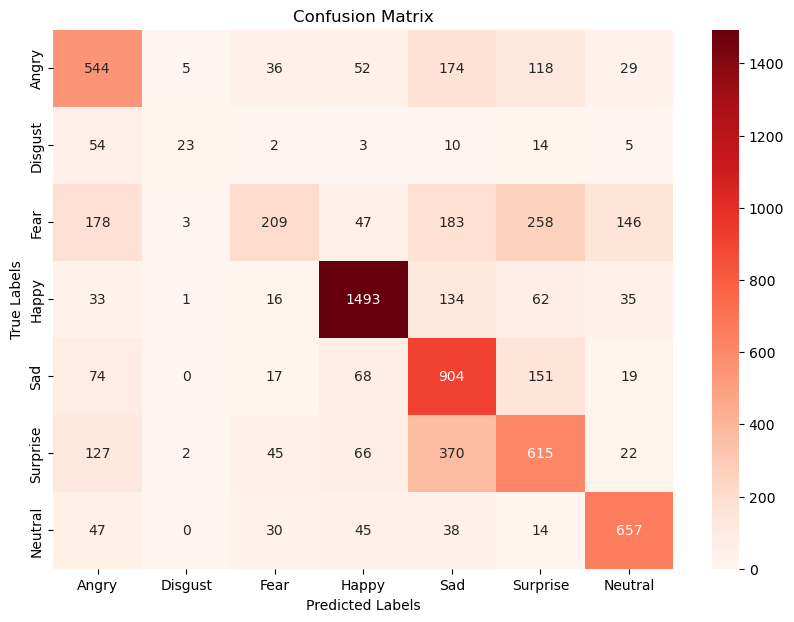

Training class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Test class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [13]:
print(f"Test Accuracy: {test_accuracy:.2f}")
y_pred = np.argmax(model.predict(testgen), axis=1)
y_true = testgen.classes
print("Classification Report:")
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix,'\n\n')
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', 
            xticklabels=list(label_map.values()), 
            yticklabels=list(label_map.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print("Training class indices:", traingen.class_indices)
print("Test class indices:", testgen.class_indices)

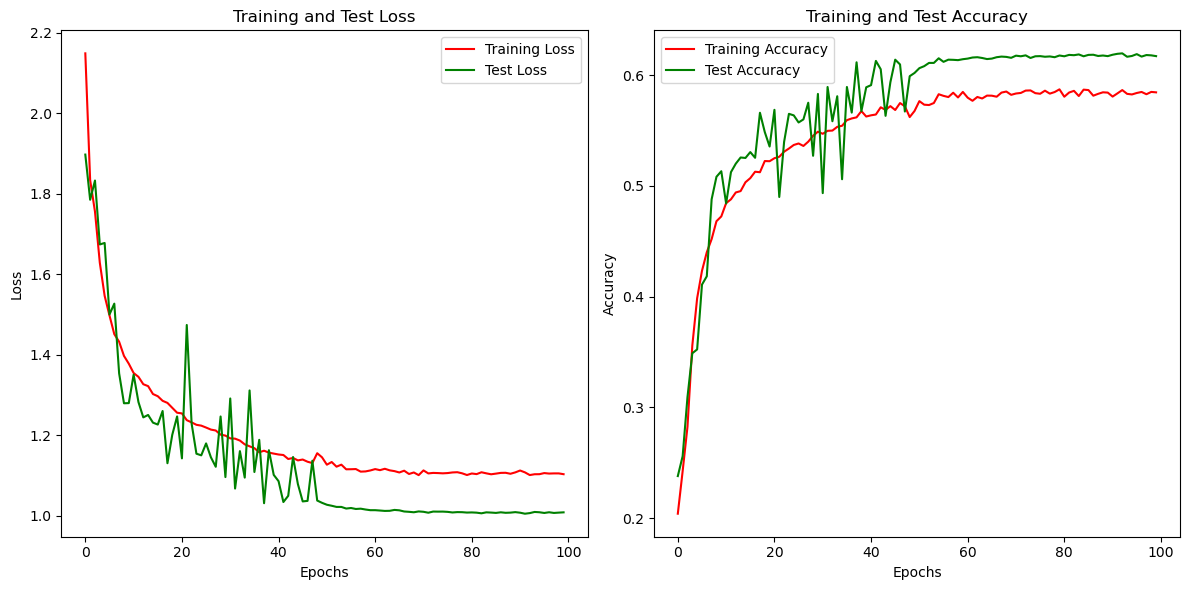

In [14]:
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Test Loss', color='green')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', color='green')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


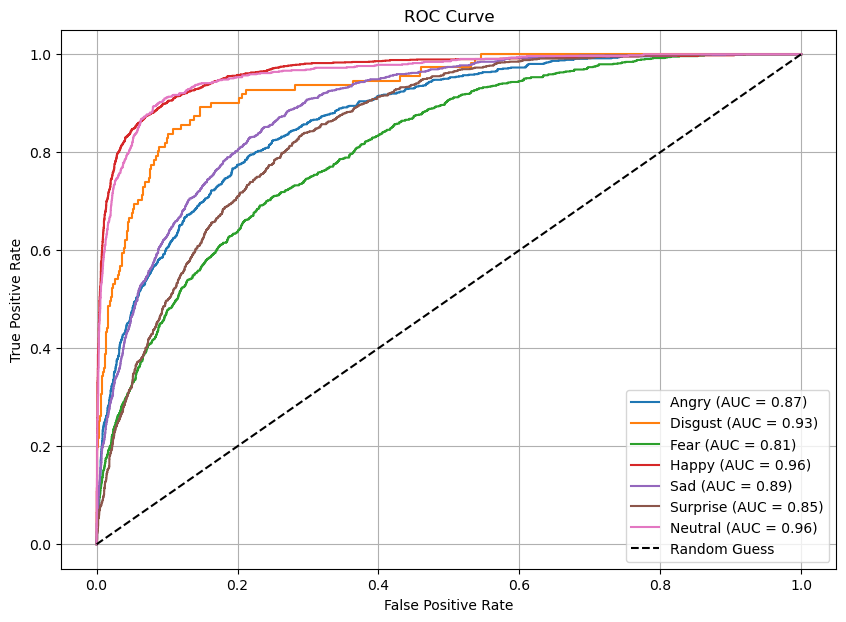

In [15]:
# Convert true labels to one-hot encoding for ROC calculations
y_true_onehot = label_binarize(y_true, classes=[0, 1, 2, 3, 4,5,6])
y_pred_prob = model.predict(testgen)

plt.figure(figsize=(10, 7))

# Plot ROC for each class
for i, class_name in label_map.items():
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()